# Определение стоимости автомобилей

Построим модель для определения стоимости автомобилей с пробегом в сервисе по продаже «Не бит, не крашен»,которая разрабатывает приложение для привлечения новых клиентов,в котором можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.
Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Загрузка и подготовка данных

Откроем файл с данными, изучим общую информацию и подготовим данные.

Данные находятся в трёх файле: 

- /datasets/autos.csv


Таким образом, исследование пройдёт в четыре этапа:

- Загрузка и подготовка данных
- Обучение моделей
- Анализ моделей
- Вывод

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,StandardScaler
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import time 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [2]:
# чтение файлов с данными и сохранение 
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
df.duplicated().sum()

4

In [7]:
# посчитаем количество пропусков
df.isna().sum().sort_values(ascending = False)  

NotRepaired          71154
VehicleType          37490
FuelType             32895
Gearbox              19833
Model                19705
DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Kilometer                0
RegistrationMonth        0
Brand                    0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [8]:
round(df.isna().sum()/df.shape[0]*100).sort_values(ascending = False) 

NotRepaired          20.0
VehicleType          11.0
FuelType              9.0
Gearbox               6.0
Model                 6.0
DateCrawled           0.0
Price                 0.0
RegistrationYear      0.0
Power                 0.0
Kilometer             0.0
RegistrationMonth     0.0
Brand                 0.0
DateCreated           0.0
NumberOfPictures      0.0
PostalCode            0.0
LastSeen              0.0
dtype: float64

<AxesSubplot:>

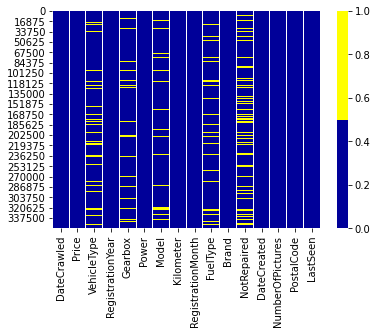

In [9]:
cols = df.columns[:] 
colours = ['#000099', '#ffff00'] 
# желтый - пропущенные данные, синий - не пропущенные
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours)) 

- В таблице 16 столбцов и 354368 строк :

Признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:

- Price — цена (евро)



1.**Пропуски в 5 столбцах**:
- NotRepaired  — была машина в ремонте или нет **20%** (Эти пропуски в данных могут быть в связи с тем, что продавец мог утаить эти данные, чтобы на первоначальном этапе поиска автомобиля, потенциальный клиент обратил внимание на его авто, также это может быть свидетельством того, что автомобиль "Не бит, не крашен")
Остальные пропуски могут свидетельствовать о проблемах в выгрузке данных,либо продавец поленился указать информацию о своем атомобиле
- VehicleType  — тип автомобильного кузова **11%**
- FuelType — тип топлива **9%** 
- Model — модель автомобиля  **6%**
- Gearbox — тип коробки передач **6%**


2.**Строчные с прописными буквами**  

3.**Есть дубликаты**

4.**Выбросы в данных**:   

- RegistrationYear — год регистрации автомобиля с 1000 г. по 9999 г.(Первый прообраз автомобиля был построен как игрушка для китайского императора членом иезуитской общины в Китае  Фердинандом Вербистом в 1672 году)
- Price — цена (евро) с 0 до 20000 
- Power — мощность (л. с.) от 0 до 20000 (Devel Sixteen (5000 л. с.).Это кажется невероятным, но автомобиль с 5-ю тысячами лошадей под капотом действительно существует!). Subaru 360 - эта Subaru оснащалась двухтактным двухцилиндровым двигателем двигателем объемом 356 куб.см. Более поздние версии автомобиля стали мощнее (36 л.с.)
- Kilometer — пробег (км) (Вроде бы всё впорядке, но ограничивается максимальными 150000, что может быть связано с возможностями сайта и ограничение стоит в данном диапазоне)



In [10]:
#для переименования столбцов вызывают метод датафреймов rename()
df = df.rename(columns={'DateCrawled': 'date_crawled', 'VehicleType': 'vehicle_type',
                        'RegistrationYear': 'registration_year', 'RegistrationMonth': 'registration_month', 'FuelType': 'fuel_type'
                        , 'NotRepaired': 'not_repaired', 'DateCreated': 'date_created', 'NumberOfPictures': 'number_of_pictures'
                        , 'PostalCode': 'postal_code','LastSeen': 'last_seen'}) 

In [11]:
df.columns = df.columns.str.lower()

In [12]:
# удалим 4 дубиката
df = df.drop_duplicates().reset_index(drop=True)

In [13]:
# функция, получающая на вход название признака, и возвращающая число пропущенных значений
def print_nan(column):
    return print('Пропущено {:.1%}'. format(df[column].isna()
                                            .value_counts()[1] / len(df), 2) + ' значений') 

In [14]:
#находим пропущенные значения
print_nan('not_repaired') 

Пропущено 20.1% значений


In [15]:
#находим пропущенные значения
print_nan('model') 

Пропущено 5.6% значений


In [16]:
#находим пропущенные значения
print_nan('fuel_type') 

Пропущено 9.3% значений


In [17]:
#находим пропущенные значения
print_nan('vehicle_type') 

Пропущено 10.6% значений


In [18]:
#находим пропущенные значения
print_nan('gearbox') 

Пропущено 5.6% значений


In [19]:
# заменим пропуски NotRepaired на значение 'по',т.к. продавец не указал информацию
df['not_repaired'] = df['not_repaired'].fillna('no')

In [20]:
# для заполнения пропущенных значений в остальных столбцах используем группировку по общим признакам автомобилей
def pass_column(column, column1, column2):
    df[column] = df.groupby([column1, column2])[column].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else 'other')))

In [21]:
pass_column('model', 'brand', 'registration_year')
pass_column('fuel_type', 'brand', 'model')
pass_column('vehicle_type', 'brand', 'model')
pass_column('gearbox', 'brand', 'model')

In [22]:
# функция, получающая на вход название признака, и возвращающая границы "усов"
def det(column):
    x = df[column].describe()
    iqr = x[6] - x[4]  # межквартирльный размах  
    left = round(x[4] - 1.5 * iqr, 2) # левый и правый "ус" 
    right = round(x[6] + 1.5 * iqr, 2)
    if left < x[3]: left = x[3]   # левый "ус" не должен быть 
    if right > x[7]: right = x[7] # правый "ус" не должен быть больше максимального значения    
    return [left, right]

In [23]:
# зададим функцию, вычисляющую долю аномальных значений
def anomalies(column):
    return 'Аномальные значения составляют {:.1%}'. format(len(df.loc[df[column] > det(column)[1]]) / len(df)) + ' от всей выборки' 

In [24]:
anomalies('registration_year')

'Аномальные значения составляют 0.0% от всей выборки'

In [25]:
df['registration_year'].value_counts(ascending = True)

8455        1
1915        1
1919        1
1920        1
3200        1
        ...  
2006    19900
2001    20123
2005    22109
1999    22727
2000    24490
Name: registration_year, Length: 151, dtype: int64

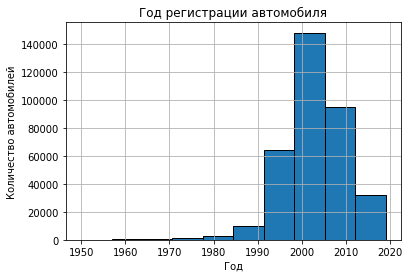

In [26]:
df['registration_year'].hist(bins=10,range=(1950,2019),edgecolor='black')
plt.title('Год регистрации автомобиля')
plt.xlabel('Год')
plt.ylabel('Количество автомобилей')
plt.show()

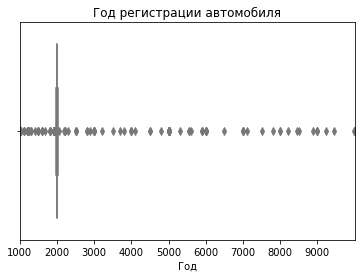

In [27]:
# построим диаграмму размаха
sns.boxplot(df['registration_year'], color='lightsteelblue') 
plt.title('Год регистрации автомобиля')
plt.xlabel('Год')
plt.xlim(1000, 9999)
plt.show()

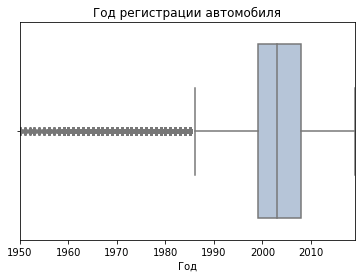

In [28]:
# построим диаграмму размаха
sns.boxplot(df['registration_year'], color='lightsteelblue') 
plt.title('Год регистрации автомобиля')
plt.xlabel('Год')
plt.xlim(1950, 2019)
plt.show()

Text(0, 0.5, 'Количество')

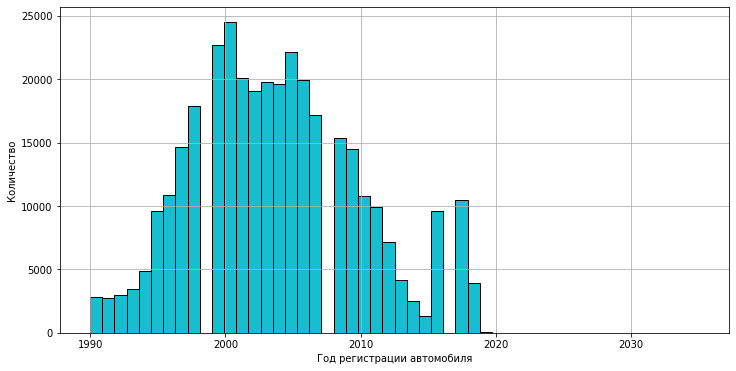

In [29]:
Q1 = df['registration_year'].quantile(0.25)
Q3 = df['registration_year'].quantile(0.75)
IQR = Q3 - Q1
fig, ax = plt.subplots()
df['registration_year'].plot(kind = 'hist', bins = 50,color='tab:cyan',edgecolor='black', grid = True, range = (Q1 - IQR, Q3 + 3*IQR), figsize = (12, 6))
ax.set_xlabel('Год регистрации автомобиля')
ax.set_ylabel('Количество')

In [30]:
df['registration_year'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

In [31]:
# для заполнения пропущенных значений в остальных столбцах используем группировку по общим признакам автомобилей
def pass_col(column, column1, column2, column3):
    df[column] = df.groupby([column1, column2, column3])[column].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else 0)))

In [32]:
df.loc[(df['registration_year'] > 2017)|(df['registration_year'] < 1955),'registration_year']= None

In [33]:
# год регистрации группируем и заполняем выбросы по бренду, мощности и коробке передач
pass_col('registration_year', 'brand', 'power','gearbox')

In [34]:
df = df.query('registration_year != 0')

До 1985 г. много выбросов и соответственно после 2022 г. автомобили еще не произведены

In [35]:
anomalies('price')

'Аномальные значения составляют 5.4% от всей выборки'

In [36]:
df['price'].value_counts(ascending = True)

384          1
10370        1
8069         1
1414         1
13440        1
         ...  
1200      4594
1000      4647
1500      5393
500       5668
0        10766
Name: price, Length: 3731, dtype: int64

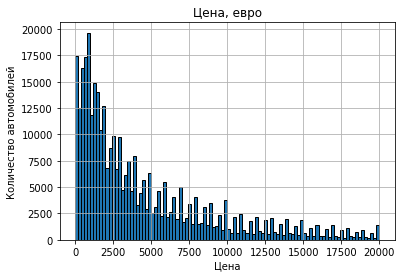

In [37]:
df['price'].hist(bins=100,range=(0,20000),edgecolor='black')
plt.title('Цена, евро')
plt.xlabel('Цена')
plt.ylabel('Количество автомобилей')
plt.show()

(0.0, 20000.0)

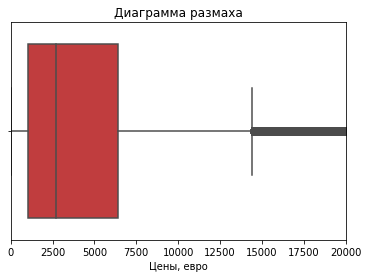

In [38]:
sns.boxplot(df['price'], color='tab:red')
plt.title('Диаграмма размаха')
plt.xlabel('Цены, евро')
plt.xlim(0, 20000)

Text(0, 0.5, 'Количество')

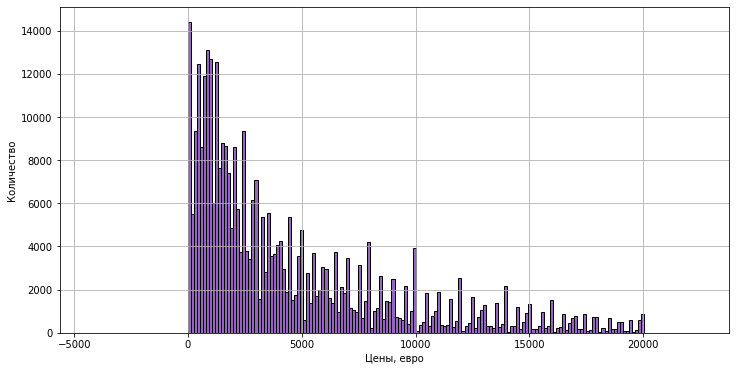

In [39]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
fig, ax = plt.subplots()
df['price'].plot(kind = 'hist', bins = 200, grid = True,color='tab:purple',edgecolor='black', range = (Q1 - IQR, Q3 + 3*IQR), figsize = (12, 6))
ax.set_xlabel('Цены, евро')
ax.set_ylabel('Количество')

In [40]:
df['price'].sort_values().unique()

array([    0,     1,     2, ..., 19998, 19999, 20000])

In [41]:
df.loc[(df['price'] < 50),'price']= None

In [42]:
#цену группируем по модели, году регистрации и типу коробки передач
pass_col('price', 'model', 'registration_year','gearbox')

In [43]:
df = df.query('price != 0')

Много с 0 ценой и выбросы начинаются от 14500 евро

In [44]:
anomalies('power')

'Аномальные значения составляют 2.1% от всей выборки'

In [45]:
df['power'].value_counts(ascending = True)

5575         1
5809         1
2389         1
16051        1
5815         1
         ...  
101      13297
150      14585
60       15897
75       24022
0        40171
Name: power, Length: 710, dtype: int64

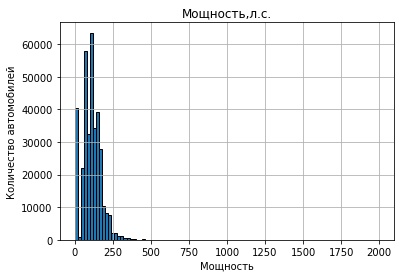

In [46]:
df['power'].hist(bins=100,range=(0,2000),edgecolor='black')
plt.title('Мощность,л.с.')
plt.xlabel('Мощность')
plt.ylabel('Количество автомобилей')
plt.show()

(0.0, 2000.0)

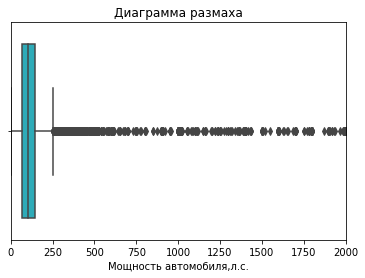

In [47]:
sns.boxplot(df['power'], color='tab:cyan')
plt.title('Диаграмма размаха')
plt.xlabel('Мощность автомобиля,л.с.')
plt.xlim(0, 2000)

Text(0, 0.5, 'Количество')

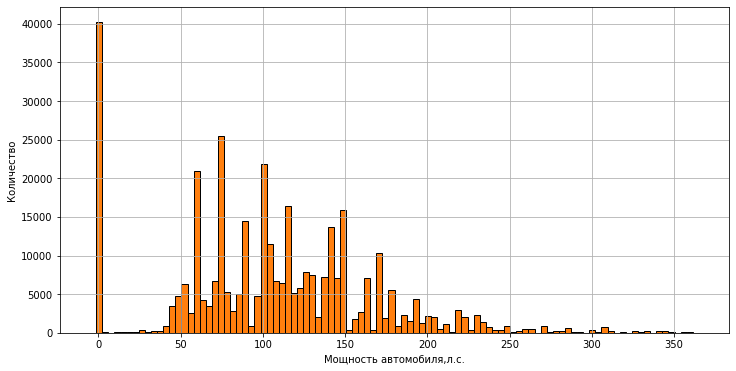

In [48]:
Q1 = df['power'].quantile(0.25)
Q3 = df['power'].quantile(0.75)
IQR = Q3 - Q1
fig, ax = plt.subplots()
df['power'].plot(kind = 'hist', bins = 100,color='tab:orange',edgecolor='black', grid = True, range = (Q1 - IQR, Q3 + 3*IQR), figsize = (12, 6))
ax.set_xlabel('Мощность автомобиля,л.с.')
ax.set_ylabel('Количество')

In [49]:
df['power'].sort_values().unique()

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

In [50]:
df.loc[(df['power'] < 50)|(df['power'] > 350),'power']= None

In [51]:
# мощность логично сгруппировать по модели, году регистрации и коробке передач
pass_col('power', 'model', 'registration_year', 'gearbox')

In [52]:
df = df.query('power != 0')

От 250 л.с. начинаются выбросы по мощности автомобиля,много автомобилей с 0 мощностью

In [53]:
df['kilometer'].value_counts(ascending = True)

10000       1187
20000       3921
30000       4386
40000       4846
50000       6169
5000        6169
60000       7370
70000       8515
80000       9983
90000      11511
100000     14768
125000     36376
150000    237827
Name: kilometer, dtype: int64

Много автомобилей с пробегом свыше 150000 км

In [54]:
df = df.drop_duplicates().reset_index(drop=True)

In [55]:
# уберем ненужные столбцы
df = df.drop(['date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen', 'registration_month'], axis=1)

In [56]:
df.describe()

,price,registration_year,power,kilometer
count,353027.000000,353027.000000,353027.000000,353027.000000
mean,4498.361749,2002.993527,117.758797,128391.341172
std,4490.734812,7.033359,50.862879,37712.369942
min,50.000000,1955.000000,50.000000,5000.000000
25%,1199.000000,1999.000000,75.000000,125000.000000
50%,2800.000000,2003.000000,109.000000,150000.000000
75%,6499.000000,2007.000000,143.000000,150000.000000
max,20000.000000,2017.000000,350.000000,150000.000000


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353027 entries, 0 to 353026
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              353027 non-null  float64
 1   vehicle_type       353027 non-null  object 
 2   registration_year  353027 non-null  float64
 3   gearbox            353027 non-null  object 
 4   power              353027 non-null  float64
 5   model              353027 non-null  object 
 6   kilometer          353027 non-null  int64  
 7   fuel_type          353027 non-null  object 
 8   brand              353027 non-null  object 
 9   not_repaired       353027 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 26.9+ MB


In [58]:
def auto(column, title):
    df[column].value_counts().sort_values(ascending=False).head(10).plot(kind='barh',edgecolor='black', grid = True)
    plt.title(title)
    plt.xlabel('Количество')
    plt.ylabel(title)
    plt.show()

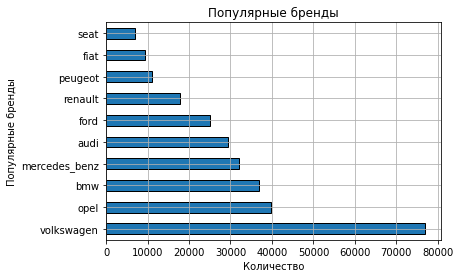

In [59]:
auto('brand', 'Популярные бренды')

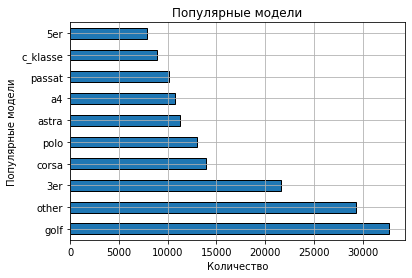

In [60]:
auto('model', 'Популярные модели')

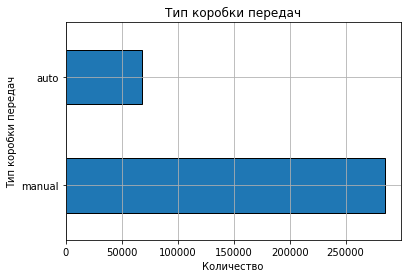

In [61]:
auto('gearbox', 'Тип коробки передач')

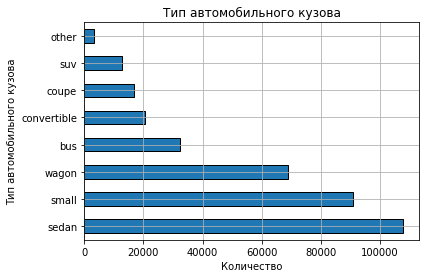

In [62]:
auto('vehicle_type', 'Тип автомобильного кузова')

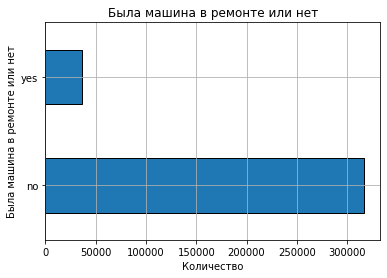

In [63]:
auto('not_repaired', 'Была машина в ремонте или нет')

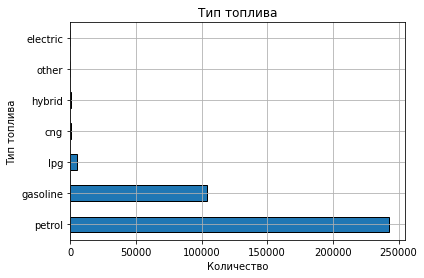

In [64]:
auto('fuel_type', 'Тип топлива')

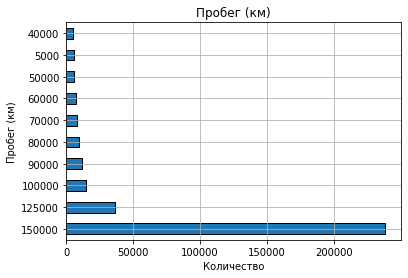

In [65]:
auto('kilometer', 'Пробег (км)')

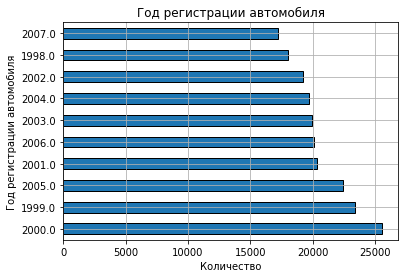

In [66]:
auto('registration_year', 'Год регистрации автомобиля')

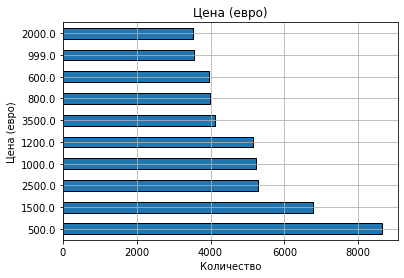

In [67]:
auto('price', 'Цена (евро)')

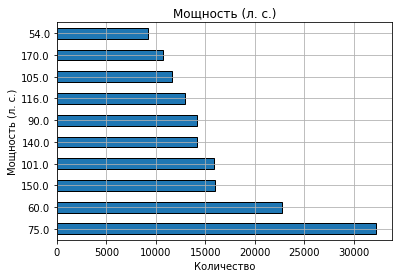

In [68]:
auto('power', 'Мощность (л. с.)')

**Вывод:**

- Заменили пропуски в 5 столбцах
- Привели к нижнему регистру столбцы
- Удалили дубликаты
- Заменили часть выбросов и удалили те,которые не смогли заменить
- Удалили ненужные столбцы
- 1 % - удаленные данные от первоначальных данных


Самые популярные:


- VehicleType — тип автомобильного кузова
 - sedan
 - small
 - wagon
- RegistrationYear — год регистрации автомобиля
 - 2000
 - 1999
 - 2005
- Gearbox — тип коробки передач
 - manual
- Power — мощность (л. с.)
 - 75
 - 60
 - 150
- Model — модель автомобиля
 - golf
 - other
 - 3er
- Kilometer — пробег (км)
 - Более 150000
 - 125000
 - 100000
- FuelType — тип топлива
 - petrol
 - gasoline
- Brand — марка автомобиля
 - wolkswagen
 - opel
 - bmw
- Price — цена (евро)
 - 500
 - 1500
 - 2500

## Обучение моделей

In [69]:
encoder = OrdinalEncoder()

encoder.fit(df[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']].astype('str'))
df[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']] = encoder.transform(df[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']].astype('str'))



In [70]:
df = pd.get_dummies(df, drop_first=True)
target = df['price']
features = df.drop('price', axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

In [71]:
numeric = ['registration_year', 'power', 'kilometer']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_train.head()
features_valid.head()

/tmp/ipykernel_155/896929365.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_155/896929365.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
73026,7.0,-0.710368,1.0,-0.842239,42.0,0.573187,6.0,24.0,0.0
281726,7.0,0.995952,1.0,3.702331,11.0,-0.089844,6.0,2.0,0.0
110835,0.0,0.284985,1.0,-0.252035,116.0,0.573187,2.0,38.0,0.0
326877,5.0,-1.136949,1.0,-0.842239,166.0,-1.813725,6.0,35.0,0.0
59284,4.0,-0.710368,0.0,0.357842,95.0,0.573187,6.0,20.0,0.0


In [72]:
%%time

model = CatBoostRegressor()
params = {
        'verbose' : [0],
        'max_depth' : [5, 10]
         }

model = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1)
model.fit(features_train, target_train)
mse = mean_squared_error(target_valid, model.predict(features_valid))
print('Лучшие параметры: ', model.best_params_)
print("RMSE = ", mse ** 0.5)

Лучшие параметры:  {'max_depth': 10, 'verbose': 0}
RMSE =  1659.8294457926252
CPU times: user 4min 26s, sys: 2.41 s, total: 4min 29s
Wall time: 4min 41s


In [73]:
%%time

model = XGBRegressor()
params = {
        'max_depth': [3, 10], 
        'eta': [0.5], 
        'seed':[12345]
        }
model = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1)
model.fit(features_train, target_train)
mse = mean_squared_error(target_valid, model.predict(features_valid))
print('Лучшие параметры: ', model.best_params_)
print("RMSE = ", mse ** 0.5)

Лучшие параметры:  {'eta': 0.5, 'max_depth': 10, 'seed': 12345}
RMSE =  1696.1379024520481
CPU times: user 18min 14s, sys: 17.2 s, total: 18min 31s
Wall time: 18min 36s


In [74]:
%%time

model = LGBMRegressor()
params = {
        'learning_rate': [0.03, 0.1],
        'max_depth': [5, 10]
         }
model = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1)
model.fit(features_train, target_train)
mse = mean_squared_error(target_valid, model.predict(features_valid))
print('Лучшие параметры: ', model.best_params_)
print("RMSE = ", mse ** 0.5)

Лучшие параметры:  {'learning_rate': 0.1, 'max_depth': 10}
RMSE =  1812.370856205536
CPU times: user 1h 8min 11s, sys: 40.3 s, total: 1h 8min 52s
Wall time: 1h 9min 14s


## Анализ моделей

Мы подготовили их и обучили модели. Нашли лучшие гиперпараметры для моделей и протестировали их, применив метрику RMSE.

In [76]:
results = {
    'Model' : ['CatBoostRegressor', 'XGBRegressor', 'LGBMRegressor'],
    'RMSE' :pd.Series([1659.83, 1696.18, 1812.37]),
    'Wall time, s': pd.Series([281, 1116, 4154]),
    }
display(pd.DataFrame(results))

,Model,RMSE,"Wall time, s"
0,CatBoostRegressor,1659.83,281
1,XGBRegressor,1696.18,1116
2,LGBMRegressor,1812.37,4154


**Вывод:**

CatBoostRegressor показал луший результат.

## Вывод

В результате работы над проектом мы нашли в исходных данных пропуски, дубликаты, множество выбросов, в результате мы удалили 1 % от первоначальных данных.

Выяснили,что самые популярные:

- тип автомобильного кузова - sedan
- год регистрации автомобиля - 2000
- тип коробки передач - manual
- мощность (л. с.) - 75
- модель автомобиля и марка автомобиля - wolkswagen golf
- пробег (км)- более 150000
- тип топлива - petrol
- цена (евро) - 500


Построили модель для определения стоимости автомобилей с пробегом в сервисе по продаже «Не бит, не крашен»,которая разрабатывает приложение для привлечения новых клиентов,в котором можно быстро узнать рыночную стоимость своего автомобиля. Т.к. заказчику выжны:
- качество предсказания;
- скорость предсказания;
- время обучения,

то можно остановить выбор на CatBoostRegressor.